<a href="https://colab.research.google.com/github/CoderSsVartak/Image-Reconstruction/blob/master/image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Image manipulation packages
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

#Tensorflow models libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model

#Alternative of pickle for larger files
import joblib

#packages required to get the data uploaded on the drive
from googleapiclient.http import MediaIoBaseDownload
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import drive
import io
import random

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
#Code to load images from Drive
def load_drive_data(file_id):

    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)
    f = joblib.load(downloaded)

    return f

#images downloaded are in the form of a dictionary, convert it to a numpy array
def dict_to_array(images):

    image_list = []
    for persons in images.keys():
        image_list.append(images[persons])
    
    return np.array(image_list)

#function to plot multiple images
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(image.shape[0], image.shape[1], image.shape[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [6]:
#images obtained are in the form of a dictionary and have values between 0-1, and are cropped so as to obtain just the facial images
#dictionary[person] = image_value

#Data description: Total facial images of 105 people with each person having a total of 6 images
image_data = load_drive_data('1QZv7mWvvF8mnT0A2mA4OFSvxF1eqPd8g')
images = dict_to_array(image_data)

In [7]:
images.shape

(630, 224, 224, 3)

In [8]:
#add noise to these facial images
# Algorithm 1, Add White Noise
def add_noise(images, mean=0.5, sigmoid=0.3, clip=True, return_params=False):
    
    random = np.random.rand(images.shape[0], images.shape[1], images.shape[2], images.shape[3])
    dist = np.random.normal(loc=mean, scale=sigmoid, size=images.shape)
    
    # print(images.shape, random.shape, dist.shape)

    images_noise = images + random * dist

    if clip:
        images_noise = np.clip(images_noise, 0.0, 1.)
    
    if return_params:
        return images_noise, random, dist
    
    return images_noise


#Algorithm 2, Add Median Blur, Gaussian Blur
#median blur can have kernel_smooth as 3 and 5 only
#every algorithm has to have kernal size as an odd number
def blur(images, kernel_size=(15, 15), kernel_smooth=5, algo='blur'):

    images_noise = []
    images = np.float32(images)
    for img in images:

        #Various Algorithms which can be implemented
        if algo.lower() == 'blur':
            images_noise.append(cv2.blur(img, kernel_size))
        elif algo.lower() == 'median':
            images_noise.append(cv2.medianBlur(img, kernel_smooth))
        elif algo.lower() == 'gauss':
            images_noise.append(cv2.GaussianBlur(img, kernel_size, cv2.BORDER_DEFAULT))

                        
    return np.array(images_noise)

#First zoom the input image and then regenerate it to create the blur effect
#The blur effect here is because of loss of pixel values during reconstruction
def zoom_blur(images, zoom_size=50, actual_size=224):

    blur_imgs = []
    for img in images:
        blur_imgs.append(cv2.resize(cv2.resize(img, (zoom_size, zoom_size)), (actual_size, actual_size)))
    
    return np.array(blur_imgs)

Actual Image


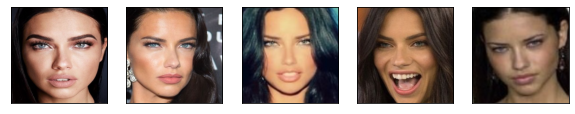

White Noise


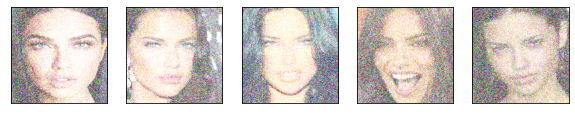

Median Blur


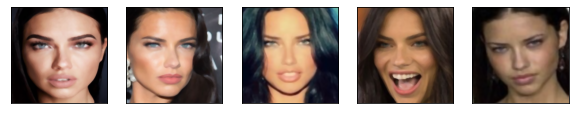

Gaussian Blur


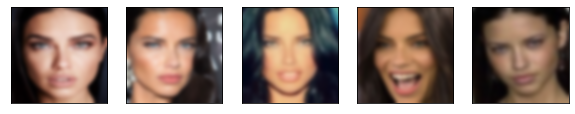

Normal Blur


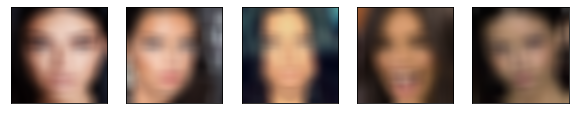

Zoom Blur


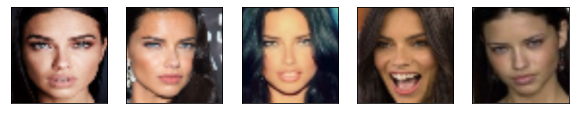

In [9]:
#Visualizing the effects of blur
print("Actual Image")
plot(images[:5])

print("White Noise")
plot(add_noise(images[:5], mean=1.0, sigmoid=0.3))

print("Median Blur")
plot(blur(images[: 5], kernel_smooth=5, algo='median'))

print("Gaussian Blur")
plot(blur(images[: 5], kernel_size=(35, 35), algo='gauss'))

print("Normal Blur")
plot(blur(images[: 5], kernel_size=(35, 35), algo='blur'))

print("Zoom Blur")
plot(zoom_blur(images[:5]))

In [10]:
#Store different sets of images in each variable and then combine them to make the training dataset
gaussian_blur = blur(images, kernel_size=(35, 35), algo='gauss')
normal_blur = blur(images, kernel_size=(35, 35), algo='blur')
zoomed = zoom_blur(images, zoom_size=40, actual_size=224)

In [11]:
#Combined these noisy images to make the input images and the actual images as the output images
noisy_images = np.concatenate((gaussian_blur, normal_blur, zoomed))
clear_images = np.concatenate((images, images, images))

In [12]:
gaussian_blur.shape, normal_blur.shape, zoomed.shape, noisy_images.shape, clear_images.shape

((630, 224, 224, 3),
 (630, 224, 224, 3),
 (630, 224, 224, 3),
 (1890, 224, 224, 3),
 (1890, 224, 224, 3))

In [13]:
#To clear memory
del(gaussian_blur)
del(normal_blur)
del(zoomed)

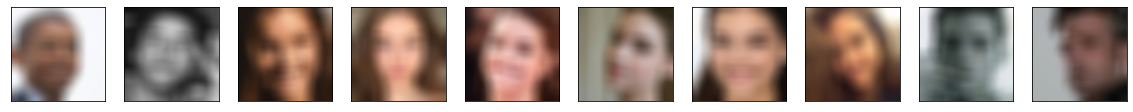

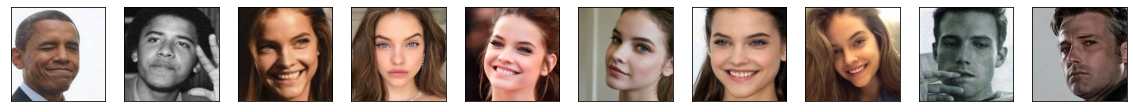

In [14]:
plot(noisy_images[700: 710], figsize=(20,20))
plot(clear_images[700: 710], figsize=(20,20))

In [ ]:
#Future works
#Remove other types of noises and train model only on one form of noise
#Increase difficulty as training continues
#Use the PSNR as a metric => 10 * log(1/mse)

In [29]:
def create_model():

    x_input = Input(shape=(224, 224, 3), dtype='float32')

    x = Conv2D(64, 9, padding='same', activation='relu')(x_input)
    x = Conv2D(32, 1, activation='relu')(x)
    x = Conv2D(3, 5, padding='same', activation='sigmoid')(x)

    model = Model(x_input, x)

    return model

In [30]:
model = create_model()

In [31]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      15616     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 32)      2080      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 3)       2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Training Phase: input = noisy_train, output = train_clear
#Test Phase: input = noisy_test, output = test_clear

train_noisy, test_noisy, train_clear, test_clear = train_test_split(noisy_images, clear_images, test_size=0.3) 

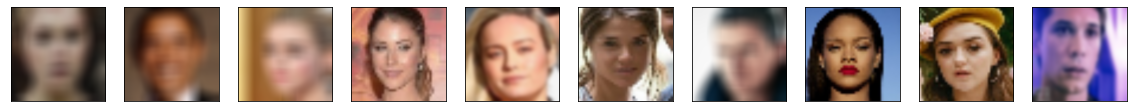

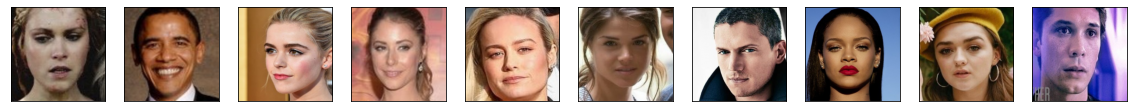

In [19]:
plot(train_noisy[:10], figsize=(20, 20))
plot(train_clear[:10], figsize=(20, 20))

# To save ram
# del(noisy_images)
# del(clear_images)

In [32]:
optimizer = 'adam'
loss = 'mse'
metrics = ['acc']
epochs = 2
batch_size = 64

In [33]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [34]:
model.fit(train_noisy, train_clear, validation_data=(test_noisy, test_clear), epochs=epochs, batch_size=batch_size)

Epoch 1/2
21/21 [==============================] - 440s 21s/step - loss: 0.0704 - acc: 0.8114 - val_loss: 0.0583 - val_acc: 0.8711
Epoch 2/2
21/21 [==============================] - 442s 21s/step - loss: 0.0478 - acc: 0.8564 - val_loss: 0.0309 - val_acc: 0.8550


Input Images


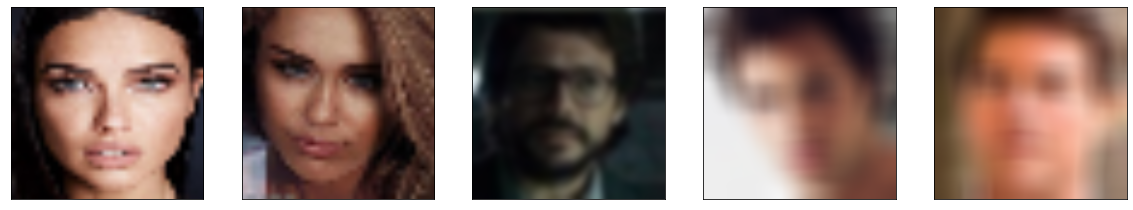

Model's Output


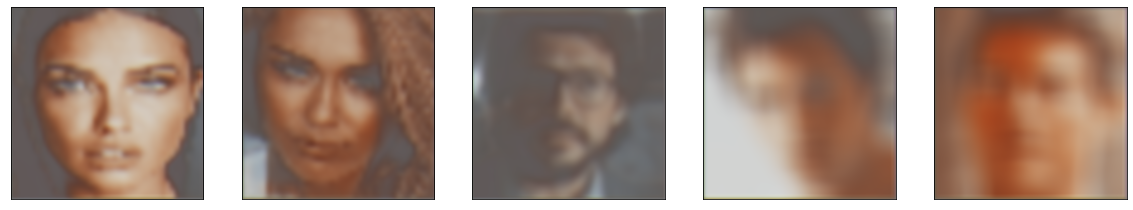

Time needed for 5 images is 0.7666053771972656.
Actual Clear Image


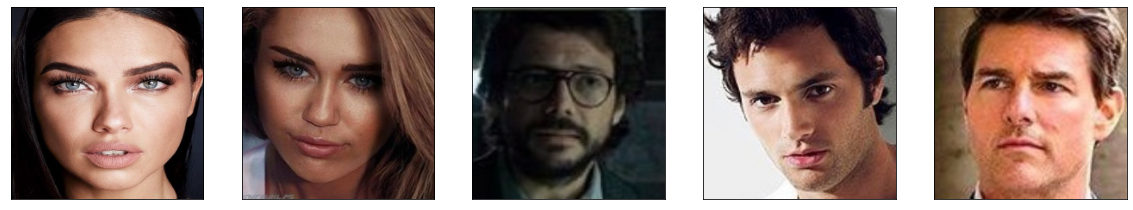

In [47]:
import time
import random

#Visualize the models predictions and also the time constraints
start = random.randint(0, test_noisy.shape[0])
count = 5

print("Input Images")
plot(test_noisy[start: start+count], figsize=(20, 20))

time_start = time.time()
print("Model's Output")
plot(model.predict(test_noisy[start: start+count]), figsize=(20, 20))
print(f'Time needed for {count} images is {time.time()-time_start}.')

print("Actual Clear Image")
plot(test_clear[start: start+count], figsize=(20, 20))